## Requirements

In [1]:
!pip install -q roboflow diffusers transformers accelerate wandb omegaconf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.4 M

In [2]:
DATASET_VERSION = 10

In [3]:
from roboflow import Roboflow

rf = Roboflow(api_key="") ## Your API Key Here
project = rf.workspace("arked").project("facades-flzke")
dataset = project.version(DATASET_VERSION).download("yolov7")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov7pytorch in progress : 85.0%
Version export complete for yolov7pytorch format



Extracting Dataset Version Zip to facades-10 in yolov7pytorch:: 100%|██████████| 219/219 [00:00<00:00, 1907.45it/s]


## Import and preprocessing

In [4]:
"""Module providing a functions to set the seed."""
import random
import torch
import numpy as np
import cv2

def set_random_seed(random_seed: int = 42) -> None:
    """Set the random seed for reproducibility. The seed is set for the
    random library, the numpy library and the OpenCV ansìd pytorch
    libraries.

    Parameters
    ----------
    random_seed : int, optional
        The random seed to use for reproducibility, by default 42.
    """
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    cv2.setRNGSeed(random_seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

RANDOM_STATE = 2808
set_random_seed(RANDOM_STATE)

In [5]:
import matplotlib.pyplot as plt
import matplotlib.path as path
import numpy as np
import os
import cv2
import yaml

# Function to parse the text label and extract polygon information
def parse_labels(label_file):
    with open(label_file, 'r') as file:
        lines = file.readlines()

    polygons = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 5:
            class_id = int(parts[0])
            coordinates = [float(coord) for coord in parts[1:]]
            num_points = len(coordinates) // 2  # Number of (x, y) pairs
            polygon = [(coordinates[i], coordinates[i + 1]) for i in range(0, len(coordinates), 2)]
            polygons.append((class_id, polygon))

    return polygons

# Function to plot bounding boxes
def plot_polygons(image_path, polygons):
    # Load the image if needed
    image = plt.imread(image_path)

    # Create a figure and axis
    fig, ax = plt.subplots(1)

    # Generate unique colors for classes
    class_ids = set([class_id for class_id, _ in polygons])
    num_classes = len(class_ids)
    colors = generate_colors(num_classes)

    # Plot each polygon
    for class_id, polygon in polygons:
        x, y = zip(*polygon)
        color = colors[class_id % num_classes]
        polygon = plt.Polygon(np.c_[x, y], linewidth=1, edgecolor=color, facecolor='none', label=f'Class {class_id}')
        ax.add_patch(polygon)

    # Display the image
    ax.imshow(image)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    # ax.legend()

    # Show the plot
    plt.show()

# Function to generate unique colors based on class ID
def generate_colors(num_classes):
    colormap = plt.cm.get_cmap('tab20', num_classes)
    colors = [colormap(i) for i in range(num_classes)]
    return colors

# Function to scale polygons to match an image size
def scale_polygons(polygons, image_size):
    scaled_polygons = []

    for class_id, polygon in polygons:
        # Scale the polygon coordinates
        scaled_polygon = [(x * image_size[0], y * image_size[1]) for x, y in polygon]
        scaled_polygons.append((class_id, scaled_polygon))

    return scaled_polygons


def enlarge_mask(mask, scaling_pixels=1):
    enlarged_mask = mask.copy()

    for s in range(1, scaling_pixels+1):
        # Create masks for shifting in all four directions
        up_mask = np.roll(mask, s, axis=0)
        down_mask = np.roll(mask, -s, axis=0)
        left_mask = np.roll(mask, s, axis=1)
        right_mask = np.roll(mask, -s, axis=1)

        # Use logical OR to combine the shifted masks
        enlarged_mask = np.logical_or(enlarged_mask, up_mask)
        enlarged_mask = np.logical_or(enlarged_mask, down_mask)
        enlarged_mask = np.logical_or(enlarged_mask, left_mask)
        enlarged_mask = np.logical_or(enlarged_mask, right_mask)

    return enlarged_mask.astype(np.uint8)

# generate mask from polygons
def generate_masks(polygons, image_size, num_samples=1, scaling_pixels=None):
    mask = np.zeros(image_size, dtype=np.uint8)
    i=0
    for class_id, polygon in polygons:
        x, y = zip(*polygon)
        # Create a Path object from the polygon coordinates
        path_polygon = path.Path(list(zip(x, y)))

        # Generate a mask for the polygon
        x, y = np.meshgrid(np.arange(image_size[0]), np.arange(image_size[1]))
        x, y = x.flatten(), y.flatten()
        points = np.vstack((x, y)).T
        mask_indices = path_polygon.contains_points(points).reshape(image_size[0], image_size[1])
        # Fill the polygon in the mask
        mask[mask_indices] = 1

        i+=1
        if (i == num_samples):
            break

    if scaling_pixels:
        mask = enlarge_mask(mask, scaling_pixels)

    return mask, class_id

def create_dataset(image_paths, label_paths, num_samples=1, resize_shape=None, scaling_pixels=None):
    images = []
    masks = []
    labels = []

    # list of all the images in the image folder
    images_names = os.listdir(image_paths)
    label_names = [image_name.replace(".jpg", ".txt") for image_name in images_names]
    for img_name, label_name in zip(images_names, label_names):
        if (label_name not in os.listdir(label_paths)):
            images_names.remove(img_name)
            label_names.remove(label_name)
        img_path = image_paths + img_name
        label_path = label_paths + label_name

        # read the rgb image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_size = (img.shape[0], img.shape[1])
        polygons = parse_labels(label_path)
        scaled_polygons = scale_polygons(polygons, image_size)
        mask, label = generate_masks(scaled_polygons, image_size, num_samples=num_samples, scaling_pixels=scaling_pixels)

        # resize the image
        if resize_shape is not None:
            img = cv2.resize(img, resize_shape, interpolation=cv2.INTER_AREA)
            mask = cv2.resize(mask, resize_shape, interpolation=cv2.INTER_AREA)

        if len(np.unique(mask)) > 1:
            images.append(img)
            masks.append(mask)
            labels.append(label)

    return np.array(images), np.array(masks), np.array(labels)

# mask the images with the masks
def mask_images(images, masks, invert=False):
    masked_images = []
    for img, mask in zip(images, masks):
        if invert:
            masked_images.append(img * (1 - mask[..., np.newaxis]))
        else:
            masked_images.append(img * mask[..., np.newaxis])
    return np.array(masked_images)

def get_label_mapping(data_yaml):
    with open(data_yaml, 'r') as file:
        data = yaml.load(file, Loader=yaml.FullLoader)

    label_mapping = {}
    for i, label in enumerate(data['names']):
        label_mapping[i] = label

    return label_mapping

In [7]:
PATH = "facades-" + str(DATASET_VERSION) + "/"

train_img_path = PATH + "train/images/"
train_label_path = PATH + "train/labels/"
data_yaml_path = PATH + '/data.yaml'

In [8]:
# create the dataset
train_images, train_masks, train_labels = create_dataset(train_img_path, train_label_path, num_samples=1)
label_mapping = get_label_mapping(data_yaml_path)

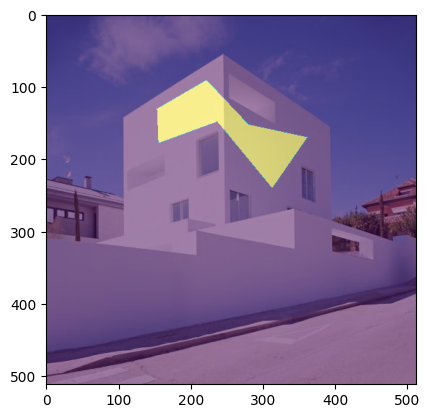


label: white


In [9]:
i = 0
plt.imshow(train_images[i])
plt.imshow(train_masks[i], alpha=0.5)
plt.show()
print()
print('label:', label_mapping[train_labels[i]])

## Dataset & Dataloader

In [10]:
from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
    DDIMScheduler,
    StableDiffusionPipeline,
    StableDiffusionInpaintPipeline,
)
from transformers import CLIPTextModel, CLIPTokenizer
from typing import List, Optional

def get_models(
    pretrained_model_name_or_path,
    pretrained_vae_name_or_path,
    device: str = "cuda:0",
    load_from_safetensor=False,
    custom_vae=False, # TODO if we want to test differents VAE
):
    if load_from_safetensor:

        print('loading VAE...')
        vae = AutoencoderKL.from_single_file(
            pretrained_vae_name_or_path,
        )
        print('loading model...')
        pipe = StableDiffusionInpaintPipeline.from_single_file(
            pretrained_model_name_or_path,
            vae=vae,
        )
        tokenizer = pipe.tokenizer
        text_encoder = pipe.text_encoder
        unet = pipe.unet

    else:
        tokenizer = CLIPTokenizer.from_pretrained(
            pretrained_model_name_or_path,
            subfolder="tokenizer",
        )

        text_encoder = CLIPTextModel.from_pretrained(
            pretrained_model_name_or_path,
            subfolder="text_encoder",
        )

        placeholder_token_ids = []

        vae = AutoencoderKL.from_pretrained(
            pretrained_model_name_or_path,
            subfolder="vae",
        )
        unet = UNet2DConditionModel.from_pretrained(
            pretrained_model_name_or_path,
            subfolder="unet",
        )
    return (
        text_encoder.to(device),
        vae.to(device),
        unet.to(device),
        tokenizer,
    )

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [11]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import random
from pathlib import Path
from typing import Optional

class InpaintLoraDataset(Dataset):
    """
    A dataset to prepare the instance and class images with the prompts for fine-tuning the model.
    It pre-processes the images and the tokenizes prompts.
    """

    def __init__(
        self,
        instance_data_root,
        tokenizer,
        label_mapping: dict,
        global_caption: str,
        token_map: Optional[dict] = None,
        size=512,
        h_flip=True,
        resize=True,
        normalize=True,
        blur_amount: int = 70,
        scaling_pixels: int = 0,
        train_inpainting: bool = True,
    ):
        self.size = size
        self.tokenizer = tokenizer
        self.resize = resize
        self.train_inpainting = train_inpainting

        if not Path(instance_data_root).exists():
            raise ValueError("Instance images root doesn't exists.")
        img_path = instance_data_root + "images/"
        label_path = instance_data_root + "labels/"

        # Prepare the instance images and masks
        self.imgs, self.masks, self.labels = create_dataset(img_path, label_path, num_samples=2, scaling_pixels=scaling_pixels)
        self.label_mapping = label_mapping

        self.global_caption = global_caption

        self.token_map = token_map

        self._length = len(self.imgs)

        self.h_flip = h_flip
        self.image_transforms = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(
                    size, interpolation=transforms.InterpolationMode.BILINEAR
                )
                if resize
                else transforms.Lambda(lambda x: x),
                transforms.CenterCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])
                if normalize
                else transforms.Lambda(lambda x: x),
            ]
        )
        self.mask_transforms = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(
                    size, interpolation=transforms.InterpolationMode.BILINEAR
                )
                if resize
                else transforms.Lambda(lambda x: x),
                transforms.CenterCrop(size),
                transforms.PILToTensor()
            ]
        )

        self.blur_amount = blur_amount

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        label = self.labels[index]

        if self.train_inpainting:
            example["instance_masks"] = self.masks[index]
            example["instance_masked_images"] = mask_images(self.imgs[index], example["instance_masks"], invert=True)
            example["instance_masked_values"] = mask_images(self.imgs[index], example["instance_masks"], invert=False)

        example["instance_images"] = self.image_transforms(self.imgs[index])
        example["instance_masked_images"] = self.image_transforms(example["instance_masked_images"])
        example["instance_masked_values"] = self.image_transforms(example["instance_masked_values"])
        example["instance_masks"] = self.mask_transforms(example["instance_masks"])

        text = label_mapping[label] + ', ' + self.global_caption.strip()

        if self.h_flip and random.random() > 0.5:
            hflip = transforms.RandomHorizontalFlip(p=1)

            example["instance_images"] = hflip(example["instance_images"])
            example["instance_masked_images"] = hflip(example["instance_masked_images"])
            example["instance_masked_values"] = hflip(example["instance_masked_values"])
            example["instance_masks"] = hflip(example["instance_masks"])

        example["instance_prompt_ids"] = self.tokenizer(
            text,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        return example

In [12]:
def inpainting_dataloader(
    dataset, batch_size, tokenizer
):
    def collate_fn(examples):
        input_ids = [example["instance_prompt_ids"] for example in examples]
        pixel_values = [example["instance_images"] for example in examples]
        mask_values = [example["instance_masked_values"] for example in examples]
        masked_image_values = [
            example["instance_masked_images"] for example in examples
        ]
        mask = [example["instance_masks"] for example in examples]

        # Concat class and instance examples for prior preservation.
        # We do this to avoid doing two forward passes.
        if examples[0].get("class_prompt_ids", None) is not None:
            input_ids += [example["class_prompt_ids"] for example in examples]
            pixel_values += [example["class_images"] for example in examples]
            mask_values += [example["class_masks"] for example in examples]
            masked_image_values += [
                example["class_masked_images"] for example in examples
            ]

        pixel_values = (
            torch.stack(pixel_values).to(memory_format=torch.contiguous_format).float()
        )
        mask_values = (
            torch.stack(mask_values).to(memory_format=torch.contiguous_format).float()
        )
        masked_image_values = (
            torch.stack(masked_image_values).to(memory_format=torch.contiguous_format).float()
        )
        mask = (
            torch.stack(mask).to(memory_format=torch.contiguous_format).float()
        )

        input_ids = tokenizer.pad(
            {"input_ids": input_ids},
            padding="max_length",
            max_length=tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids

        batch = {
            "input_ids": input_ids,
            "pixel_values": pixel_values,
            "mask_values": mask_values,
            "masked_image_values": masked_image_values,
            "mask": mask,
        }

        return batch

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        shuffle=True,
        collate_fn=collate_fn,
    )

    return train_dataloader

## Model

In [13]:
from huggingface_hub import hf_hub_download

realisticVision_path = hf_hub_download(repo_id="SG161222/Realistic_Vision_V5.1_noVAE", filename="Realistic_Vision_V5.1-inpainting.safetensors", local_dir='.')
vae_path = hf_hub_download(repo_id="stabilityai/sd-vae-ft-mse-original", filename="vae-ft-mse-840000-ema-pruned.safetensors", local_dir='.')

In [14]:
text_encoder, vae, unet, tokenizer = get_models(
    realisticVision_path,
    vae_path,
    device="cuda:0",
    load_from_safetensor=True,
)

In [15]:
noise_scheduler = DDIMScheduler.from_pretrained(
    'SG161222/Realistic_Vision_V5.1_noVAE', subfolder="scheduler"
)

In [16]:
global_caption = 'arkedfacades'

In [17]:
yaml_path = PATH + 'data.yaml'
label_mapping = get_label_mapping(yaml_path)

In [18]:
train_dataset = InpaintLoraDataset(
    instance_data_root= PATH+"train/",
    tokenizer=tokenizer,
    label_mapping=label_mapping,
    global_caption=global_caption,
    size=512,
    h_flip=False,
    resize=True,
    normalize=True,
    blur_amount=70,
    scaling_pixels=4,
)

In [19]:
valid_dataset = InpaintLoraDataset(
    instance_data_root=PATH+"valid/",
    tokenizer=tokenizer,
    label_mapping=label_mapping,
    global_caption=global_caption,
    size=512,
    h_flip=False,
    resize=True,
    normalize=False,
    blur_amount=70,
    scaling_pixels=4,
)

In [20]:
len(train_dataset)

102

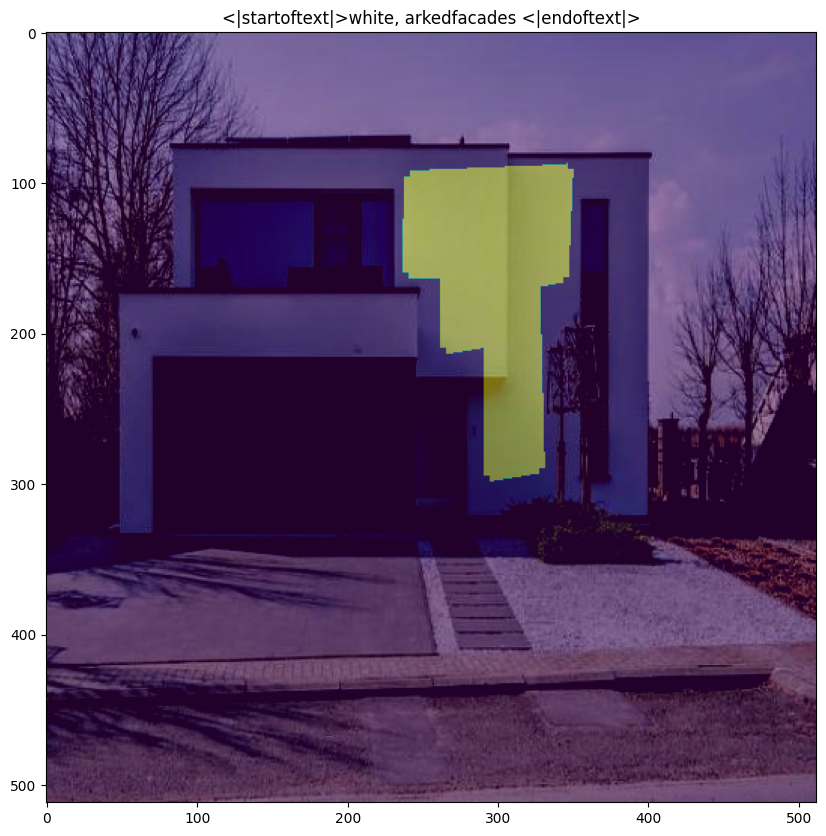

In [21]:
example = train_dataset[30]

# plot the mask on the image
plt.figure(figsize=(10, 10))
plt.imshow(example["instance_images"].permute(1, 2, 0))
plt.imshow(example["instance_masks"].permute(1, 2, 0), alpha=0.5)
plt.title(tokenizer.decode(example['instance_prompt_ids']))
plt.show()

In [22]:
train_batch_size=2
valid_batch_size=1

train_dataloader = inpainting_dataloader(
    train_dataset,
    batch_size=train_batch_size,
    tokenizer=tokenizer
)
valid_dataloader = inpainting_dataloader(
    valid_dataset,
    batch_size=valid_batch_size,
    tokenizer=tokenizer
)

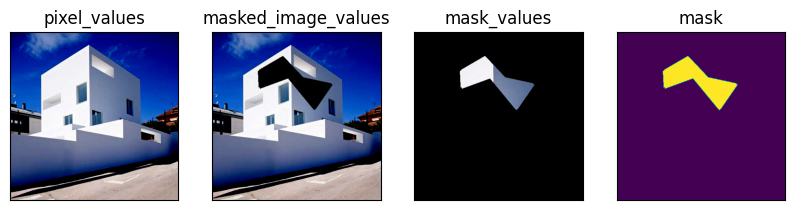

In [23]:
batch = next(iter(train_dataloader))

# plot the batch
plt.figure(figsize=(10, 10))
plt.subplot(1, 4, 1)
plt.title("pixel_values")
plt.imshow(batch["pixel_values"][0].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 4, 2)
plt.title("masked_image_values")
plt.imshow(batch["masked_image_values"][0].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 4, 3)
plt.title("mask_values")
plt.imshow(batch["mask_values"][0].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 4, 4)
plt.title("mask")
plt.imshow(batch["mask"][0].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.show()

## Training

In [24]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.checkpoint

def loss_step(
    batch,
    unet,
    vae,
    text_encoder,
    scheduler,
    t_mutliplier=1.0,
    mixed_precision=False,
    mask_temperature=1.0,
    vae_scale_factor=8,
):
    weight_dtype = torch.float32

    # encode the image
    latents = vae.encode(
            batch["pixel_values"].to(dtype=weight_dtype).to(unet.device)
        ).latent_dist.sample()


    # encode the masked image
    masked_image_latents = vae.encode(
                batch["masked_image_values"].to(dtype=weight_dtype).to(unet.device)
            ).latent_dist.sample()
    masked_image_latents = masked_image_latents * vae.config.scaling_factor
    latents = latents * vae.config.scaling_factor

    # scale the mask
    mask = F.interpolate(
                batch["mask"].to(dtype=weight_dtype).to(unet.device),
                scale_factor=1 / 8,
            )

    noise = torch.randn_like(latents)
    bsz = latents.shape[0]

    timesteps = torch.randint(
        0,
        int(scheduler.config.num_train_timesteps * t_mutliplier),
        (bsz,),
        device=latents.device,
    )
    timesteps = timesteps.long()

    noisy_latents = scheduler.add_noise(latents, noise, timesteps)

    latent_model_input = torch.cat(
            [noisy_latents, mask, masked_image_latents], dim=1
        )

    if mixed_precision:
        with torch.cuda.amp.autocast():

            encoder_hidden_states = text_encoder(
                batch["input_ids"].to(text_encoder.device)
            )[0]

            model_pred = unet(latent_model_input, timesteps, encoder_hidden_states).sample
    else:
        encoder_hidden_states = text_encoder(
            batch["input_ids"].to(text_encoder.device)
        )[0]

        model_pred = unet(latent_model_input, timesteps, encoder_hidden_states).sample
    if scheduler.config.prediction_type == "epsilon":
        target = noise
    elif scheduler.config.prediction_type == "v_prediction":
        target = scheduler.get_velocity(latents, noise, timesteps)
    else:
        raise ValueError(f"Unknown prediction type {scheduler.config.prediction_type}")

    if batch.get("mask", None) is not None:

        mask = (
            batch["mask"]
            .to(model_pred.device)
            .reshape(
                model_pred.shape[0], 1, model_pred.shape[2] * vae_scale_factor, model_pred.shape[3] * vae_scale_factor
            )
        )
        # resize to match model_pred
        mask = F.interpolate(
            mask.float(),
            size=model_pred.shape[-2:],
            mode="nearest",
        )

        mask = mask.pow(mask_temperature)

        mask = mask / mask.max()

        model_pred = model_pred * mask

        target = target * mask

    loss = (
        F.mse_loss(model_pred.float(), target.float(), reduction="none")
        .mean([1, 2, 3])
        .mean()
    )

    return loss

In [25]:
from tqdm import tqdm
import itertools
from diffusers.utils.import_utils import is_xformers_available

weight_dtype = torch.float16

unet_lr = 2e-4
ti_lr = 1e-5
weight_decay_lora = 1e-3
weight_decay_ti = 1e-4
gradient_checkpointing = False
mixed_precision = False
use_xformers = True
train_lora = True
train_text_encoder = False
train_ti = False
clip_ti_decay = False # check well what this is doing

# Freeze all weights
unet.requires_grad_(False)
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

if gradient_checkpointing:
    unet.enable_gradient_checkpointing()

if use_xformers and is_xformers_available():
    unet.enable_xformers_memory_efficient_attention()

text_encoder_params = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)

if train_text_encoder:
    for param in text_encoder_params:
        param.requires_grad = True
else:
    for param in text_encoder_params:
        param.requires_grad = False

In [26]:
from torch import optim
from torch.cuda import amp
from diffusers.optimization import get_scheduler
from lora import inject_trainable_lora

lora_unet_target_modules={"CrossAttention", "Attention", "GEGLU"}

lora_dropout_p = 0.1
lora_rank = 8
lora_scale = 1.0


unet_lora_params, unet_lora_params_names = inject_trainable_lora(
    unet,
    r=lora_rank,
    target_replace_module=lora_unet_target_modules,
    dropout_p=lora_dropout_p,
    scale=lora_scale,
)

unet_params_to_optimize = [
    {"params": itertools.chain(*unet_lora_params), "lr": unet_lr},
]

if mixed_precision:
    scaler = torch.cuda.amp.GradScaler()

optimizer_lora = optim.AdamW(
    unet_params_to_optimize,
    lr=unet_lr,
    weight_decay=weight_decay_lora,
)

if train_ti:
    for p in text_encoder.get_input_embeddings().parameters():
        p.requires_grad_(True)
    optimizer_ti = optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),
        lr=ti_lr,
        weight_decay=weight_decay_ti,
    )

"""if mixed_precision:
    unet, optimizer = amp.initialize(unet, optimizer, opt_level="O1")"""

unet.train()
if train_text_encoder:
    text_encoder.train()

In [27]:
sum(p.numel() for p in unet.parameters() if p.requires_grad) # 2492928

2492928

In [28]:
sum(p.numel() for p in text_encoder.parameters() if p.requires_grad)

0

In [29]:
import wandb

wandb.login(key='') ## Your API Key Here
wandb.init(project="inpainting-lora", entity='arked')

wandb.config.update(
    {
        "unet_lr": unet_lr,
        "text_encoder_lr": ti_lr,
        "weight_decay_lora": weight_decay_lora,
        "gradient_checkpointing": gradient_checkpointing,
        "mixed_precision": mixed_precision,
        "use_xformers": use_xformers,
        "train_text_encoder": train_text_encoder,
        "lora_unet_target_modules": lora_unet_target_modules,
        "lora_dropout_p": lora_dropout_p,
        "lora_rank": lora_rank,
        "lora_scale": lora_scale,
    }
)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: maidacundo (arked). Use `wandb login --relogin` to force relogin


In [35]:
!zip -r checkpoints.zip checkpoints

updating: checkpoints/ (stored 0%)
  adding: checkpoints/lora_inpainting_1.pt (deflated 7%)
  adding: checkpoints/lora_inpainting_5.pt (deflated 7%)
  adding: checkpoints/lora_inpainting_4.pt (deflated 7%)
  adding: checkpoints/lora_inpainting_3.pt (deflated 7%)
  adding: checkpoints/lora_inpainting_0.pt (deflated 7%)
  adding: checkpoints/lora_inpainting_2.pt (deflated 7%)
  adding: checkpoints/lora_inpainting_6.pt (deflated 7%)


In [30]:
placeholder_token_ids = tokenizer(global_caption).get('input_ids')

In [31]:
index_no_updates = torch.arange(len(tokenizer)) != -1

for tok_id in placeholder_token_ids:
    index_no_updates[tok_id] = False

In [ ]:
import math
from tqdm import tqdm
from diffusers import StableDiffusionInpaintPipeline
from lora import save_lora_weight

# TODO parametrize

log_wandb = True
g_cuda = torch.Generator(device='cuda').manual_seed(RANDOM_STATE)
mask_temperature = 1.0

num_steps = 4000
save_steps = len(train_dataloader) * 10
lr_warmup_steps = 150
max_train_steps = 4000

test_strengths = [0.99]
test_prompts = ['white', 'brick']

lr_scheduler_lora = get_scheduler(
    "cosine_with_restarts",
    optimizer=optimizer_lora,
    num_warmup_steps=lr_warmup_steps,
    num_training_steps=max_train_steps,
    num_cycles=10,
)

if train_ti:
    lr_scheduler_ti = get_scheduler(
        "cosine",
        optimizer=optimizer_ti,
        num_warmup_steps=lr_warmup_steps,
        num_training_steps=max_train_steps,
    )

import os

directory_name = "checkpoints"

if not os.path.exists(directory_name):
    os.makedirs(directory_name)
    print(f"Directory '{directory_name}' created.")
else:
    print(f"Directory '{directory_name}' already exists.")

loss_sum = 0.0
progress_bar = tqdm(range(num_steps))
progress_bar.set_description("Steps")
global_step = 0

loss_sum_lora = 0.0
loss_sum_ti = 0.0

checkpoint_num = 0

# training

if train_ti:
    orig_embeds_params = text_encoder.get_input_embeddings().weight.data.clone()
    index_updates = ~index_no_updates

for epoch in range(math.ceil(num_steps / len(train_dataloader))):
    for batch in train_dataloader:
        # TRAINING TEXTUAL INVERSION
        if train_ti:
            unet.eval()
            text_encoder.train()

            lr_scheduler_ti.step()
            optimizer_ti.zero_grad()

            loss_ti = loss_step(
                batch,
                unet,
                vae,
                text_encoder,
                noise_scheduler,
                t_mutliplier=0.8,
                mixed_precision=True,
                mask_temperature=mask_temperature,
            )
            loss_ti.backward()
            loss_sum_ti += loss_ti.detach().item()

            optimizer_ti.step()

            with torch.no_grad():
                # normalize embeddings
                if clip_ti_decay:
                    pre_norm = (
                        text_encoder.get_input_embeddings()
                        .weight[index_updates, :]
                        .norm(dim=-1, keepdim=True)
                    )

                    lambda_ = min(1.0, 100 * lr_scheduler_ti.get_last_lr()[0])
                    text_encoder.get_input_embeddings().weight[
                        index_updates
                    ] = F.normalize(
                        text_encoder.get_input_embeddings().weight[
                            index_updates, :
                        ],
                        dim=-1,
                    ) * (
                        pre_norm + lambda_ * (0.4 - pre_norm)
                    )

                current_norm = (
                    text_encoder.get_input_embeddings()
                    .weight[index_updates, :]
                    .norm(dim=-1)
                )

                text_encoder.get_input_embeddings().weight[
                    index_no_updates
                ] = orig_embeds_params[index_no_updates]

                logs_ti = {
                      "loss_ti": loss_ti.detach().item(),
                      "lr_ti": lr_scheduler_ti.get_last_lr()[0],
                      "current_norm_ti": current_norm
                  }
                progress_bar.set_postfix(**logs_ti)
                wandb.log(logs_ti)
                unet.train()
                text_encoder.eval()

        # TRAINING UNET LORA
        lr_scheduler_lora.step()

        optimizer_lora.zero_grad()

        loss_lora = loss_step(
            batch,
            unet,
            vae,
            text_encoder,
            noise_scheduler,
            t_mutliplier=0.8,
            mixed_precision=True,
            mask_temperature=mask_temperature,
        )
        loss_sum_lora += loss_lora.detach().item()

        loss_lora.backward()
        torch.nn.utils.clip_grad_norm_(
            itertools.chain(unet.parameters(), text_encoder.parameters()), 1.0
        )
        optimizer_lora.step()
        progress_bar.update(1)
        logs = {
            "loss_lora": loss_lora.detach().item(),
            "lr_lora": lr_scheduler_lora.get_last_lr()[0],
        }
        progress_bar.set_postfix(**logs)
        wandb.log(logs)

        global_step += 1

        if global_step % save_steps == 0:

            if log_wandb:
                with torch.no_grad():
                    pipe = StableDiffusionInpaintPipeline(
                                vae=vae,
                                text_encoder=text_encoder,
                                tokenizer=tokenizer,
                                unet=unet,
                                scheduler=noise_scheduler,
                                safety_checker=None,
                                feature_extractor=None,
                            )
                    for prompt in test_prompts:
                        images_log = {}
                        for strength in test_strengths:
                            examples = []
                            prompt = prompt + ', ' + global_caption
                            for example in valid_dataset:

                                image = example["instance_images"]
                                mask_image = example["instance_masks"]

                                generated_image = pipe(prompt=prompt,
                                                      image=image,
                                                      mask_image=mask_image,
                                                      generator=g_cuda,
                                                      num_inference_steps=20,
                                                      height=image.shape[1],
                                                      width=image.shape[2],
                                                      negative_prompt='door, window',
                                                      strength=strength,
                                                      ).images[0]
                                image = wandb.Image(generated_image)
                                examples.append(image)
                            images_log[prompt] = examples
                        wandb.log({f"validation images": images_log})
                save_path = f"{directory_name}/lora_inpainting_{checkpoint_num}.pt"
                save_lora_weight(
                    unet, save_path, target_replace_module=lora_unet_target_modules
                )
                print("Lora saved to ", save_path)
                checkpoint_num+=1
        if global_step >= num_steps:
            break